# I. Requirements

In [115]:
library(tidyverse)
library(DBI)
library(RSQLite)
library(reshape2)
library(data.table)
library(dplyr)
library(knitr)
library(psych)
library(ggfortify)
library("factoextra")
library("FactoMineR")
library(yardstick)
library(ggplot2)
library(vcdExtra)

# II. Read data

In [116]:
soccer <- dbConnect(SQLite(), 
                 "../input/soccer/database.sqlite")
## list all tables
tables <- dbListTables(soccer)

## exclude sqlite_sequence (contains table information)
tables <- tables[tables != "sqlite_sequence"]
lDataFrames <- vector("list", length=length(tables))

## create a data.frame for each table
for (i in seq(along=tables)) {
  lDataFrames[[i]] <- 
    dbGetQuery(conn=soccer, 
               statement=paste("SELECT * FROM '", 
                               tables[[i]], "'", sep=""))
}
## create a data.frame for each table
for (i in seq(along=tables)) {
  lDataFrames[[i]] <- 
    dbGetQuery(conn=soccer, 
               statement=paste("SELECT * FROM '", 
                               tables[[i]], "'", sep=""))
}

In [117]:
# create dataframes
country <-  data.frame(lDataFrames[1])
league  <-  data.frame(lDataFrames[2])
match   <-  data.frame(lDataFrames[3])
player  <-  data.frame(lDataFrames[4])
team    <-  data.frame(lDataFrames[6])

# III. Preprocessing

### 1. Winning rate calculation

In [118]:
scoring <- function(x){  
    if (x==0) {
        ans = 1/3
    }else if (x>0){
        ans = 1
    }else{
        ans = 0}
    return(ans)
    }
match_score <- match %>% select(match_api_id,date,home_team_api_id,away_team_api_id,home_team_goal, away_team_goal)
team <- team %>% select(team_api_id,team_long_name)
match_score$home_score <- (match$home_team_goal - match$away_team_goal)
match_score$away_score <- - match_score$home_score
match_score$home_win_rate <- as.numeric(lapply(match_score$home_score,FUN=scoring))
match_score$away_win_rate <- as.numeric(lapply(match_score$away_score,FUN=scoring))
match_home <- match_score %>% select(match_api_id,date,home_team_api_id,home_score,home_win_rate) %>% 
  rename(
    team_api_id = home_team_api_id,
    score = home_score,
    win_rate = home_win_rate
    )
match_away <- match_score %>% select(match_api_id,date,away_team_api_id,away_score, away_win_rate) %>% 
  rename(
    team_api_id = away_team_api_id,
    score = away_score,
    win_rate = away_win_rate
    )
total <- rbind(match_home, match_away)
total$date <- as.Date(total$date)
head(arrange(total,match_api_id))
match14 = with(total, total[(date >= "2014-01-01" & date < "2015-01-01"),])
match15 = with(total, total[(date >= "2015-01-01" & date < "2016-01-01"),])
df14 = subset(match14, select=-c(date))
df15 = subset(match15, select=-c(date))
team_ranking14_byscore <- aggregate(df14$score, by=list(team_api_id=df14$team_api_id), FUN=mean) %>% rename(score=x)
team_ranking15_byscore <- aggregate(df15$score, by=list(team_api_id=df15$team_api_id), FUN=mean) %>% rename(score=x)
team_ranking14_bywin <- aggregate(df14$win_rate, by=list(team_api_id=df14$team_api_id), FUN=mean) %>% rename(win_rate=x)
team_ranking15_bywin <- aggregate(df15$win_rate, by=list(team_api_id=df15$team_api_id), FUN=mean) %>% rename(win_rate=x)
team_ranking14 <- merge(team,team_ranking14_byscore, by="team_api_id",all.team_ranking14_byscore = TRUE)
team_ranking15 <- merge(team,team_ranking15_byscore,by="team_api_id",all.team_ranking14_byscore = TRUE)
team_ranking14 <- arrange(merge(team_ranking14,team_ranking14_bywin, by="team_api_id"),-win_rate)
team_ranking15 <- arrange(merge(team_ranking15,team_ranking15_bywin,by="team_api_id"),-win_rate)

,match_api_id,date,team_api_id,score,win_rate
,<int>,<date>,<int>,<int>,<dbl>
1,483129,2008-08-09,8583,1,1
2,483129,2008-08-09,9830,-1,0
3,483130,2008-08-09,9827,1,1
4,483130,2008-08-09,7819,-1,0
5,483131,2008-08-09,9746,1,1
6,483131,2008-08-09,9831,-1,0


In [119]:
team_ranking14
team_ranking15

team_api_id,team_long_name,score,win_rate
<int>,<chr>,<dbl>,<dbl>
9772,SL Benfica,1.6333333,0.8666667
9823,FC Bayern Munich,2.1142857,0.8666667
9885,Juventus,1.5135135,0.8558559
9925,Celtic,1.8684211,0.7894737
8633,Real Madrid CF,2.2222222,0.7870370
8455,Chelsea,1.4473684,0.7719298
8456,Manchester City,1.4736842,0.7719298
8640,PSV,1.1818182,0.7676768
9931,FC Basel,1.1944444,0.7407407


team_api_id,team_long_name,score,win_rate
<int>,<chr>,<dbl>,<dbl>
9773,FC Porto,1.7647059,0.8529412
9847,Paris Saint-Germain,1.7631579,0.8421053
8634,FC Barcelona,2.1052632,0.8245614
9768,Sporting CP,1.2058824,0.8235294
9925,Celtic,1.9487179,0.8205128
8640,PSV,1.4705882,0.8137255
9823,FC Bayern Munich,1.8529412,0.7843137
9772,SL Benfica,2.0588235,0.7745098
8633,Real Madrid CF,1.6750000,0.7416667


### 2. Team - players aggregation

In [120]:
team = data.frame(lDataFrames[6])
# select relevant columns
country <- select(country, id, name) %>% rename(country_id = id)  %>% rename(country_name = name)   # use country_id as key for join
league  <- select(league, country_id, name) %>% rename(league_name = name) # use country_id as key for join
match   <- select(match, id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11, goal, shoton, shotoff, foulcommit, card, cross, corner, possession)
player  <- select(player,player_api_id, player_name) # use player_api_id as key for join
team    <- select(team, team_api_id, team_long_name, team_short_name) # use team_api_id as key for join

# agrregation
others = colnames(match)[1:11]
players = colnames(match)[12:33]
flatten <- melt(match, id = others, measure = players, na.rm = TRUE, value.name = "player_api_id") %>% 
  mutate(team_api_id = 
           ifelse(grepl("home",variable),home_team_api_id, 
                  ifelse(grepl("away",variable),away_team_api_id,NA))) %>%  
  left_join(country, by = "country_id")    %>% 
  left_join(league,  by = "country_id")    %>%  
  left_join(team,    by = "team_api_id")   %>%
  left_join(player,  by = "player_api_id") %>% 
  separate(season, into = c("season_start","season_end"), sep = "/", convert = TRUE) 
head(flatten)

# Filter
team_players <- select(flatten, season_start, season_end, 
                       country_name, league_name, player_api_id, 
                       team_api_id, team_long_name, team_short_name,
                       player_name)

team_players_2015 <- team_players %>% filter(season_start == 2015)
team_players_2014 <- team_players %>% filter(season_start == 2014)

Warning message in melt(match, id = others, measure = players, na.rm = TRUE, value.name = "player_api_id"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(match). In the next version, this warning will become an error.”


,id,country_id,league_id,season_start,season_end,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,variable,player_api_id,team_api_id,country_name,league_name,team_long_name,team_short_name,player_name
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,145,1,1,2008,2009,24,2009-02-28 00:00:00,493016,9996,8635,1,1,home_player_1,39890,9996,Belgium,Belgium Jupiler League,Royal Excel Mouscron,MOU,Mark Volders
2,146,1,1,2008,2009,24,2009-02-27 00:00:00,493017,8203,9987,2,1,home_player_1,38327,8203,Belgium,Belgium Jupiler League,KV Mechelen,MEC,Wouter Biebauw
3,147,1,1,2008,2009,24,2009-02-28 00:00:00,493018,9986,9998,3,0,home_player_1,95597,9986,Belgium,Belgium Jupiler League,Sporting Charleroi,CHA,Bertrand Laquait
4,149,1,1,2008,2009,24,2009-03-01 00:00:00,493020,9994,9991,0,1,home_player_1,30934,9994,Belgium,Belgium Jupiler League,Sporting Lokeren,LOK,Boubacar Barry Copa
5,150,1,1,2008,2009,24,2009-02-28 00:00:00,493021,8342,9999,2,1,home_player_1,37990,8342,Belgium,Belgium Jupiler League,Club Brugge KV,CLB,Stijn Stijnen
6,151,1,1,2008,2009,24,2009-02-28 00:00:00,493022,9993,8571,3,0,home_player_1,38391,9993,Belgium,Belgium Jupiler League,Beerschot AC,BAC,Silvio Proto


In [121]:
head(team_players_2014)
head(team_players_2015)

,season_start,season_end,country_name,league_name,player_api_id,team_api_id,team_long_name,team_short_name,player_name
,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,2014,2015,Belgium,Belgium Jupiler League,20747,9985,Standard de Liège,STL,Eiji Kawashima
2,2014,2015,Belgium,Belgium Jupiler League,208699,8475,Waasland-Beveren,WAA,Colin Coosemans
3,2014,2015,Belgium,Belgium Jupiler League,67949,9984,KSV Cercle Brugge,CEB,Olivier Werner
4,2014,2015,Belgium,Belgium Jupiler League,270473,9989,Lierse SK,LIE,Igor Berezovsky
5,2014,2015,Belgium,Belgium Jupiler League,346114,10001,KVC Westerlo,WES,Koen Van Langendonck
6,2014,2015,Belgium,Belgium Jupiler League,13131,8203,KV Mechelen,MEC,Tomislav Pacovski


,season_start,season_end,country_name,league_name,player_api_id,team_api_id,team_long_name,team_short_name,player_name
,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,2015,2016,Belgium,Belgium Jupiler League,242243,9997,Sint-Truidense VV,STT,William Dutoit
2,2015,2016,Belgium,Belgium Jupiler League,206592,8571,KV Kortrijk,KOR,Darren Keet
3,2015,2016,Belgium,Belgium Jupiler League,91929,9987,KRC Genk,GEN,Laszlo Koteles
4,2015,2016,Belgium,Belgium Jupiler League,107806,8573,KV Oostende,OOS,Didier Ovono
5,2015,2016,Belgium,Belgium Jupiler League,37900,10000,SV Zulte-Waregem,ZUL,Sammy Bossuyt
6,2015,2016,Belgium,Belgium Jupiler League,346114,10001,KVC Westerlo,WES,Koen Van Langendonck


In [122]:
head(team_ranking14)
head(team_ranking15)

,team_api_id,team_long_name,score,win_rate
,<int>,<chr>,<dbl>,<dbl>
1,9772,SL Benfica,1.633333,0.8666667
2,9823,FC Bayern Munich,2.114286,0.8666667
3,9885,Juventus,1.513514,0.8558559
4,9925,Celtic,1.868421,0.7894737
5,8633,Real Madrid CF,2.222222,0.7870370
6,8455,Chelsea,1.447368,0.7719298


,team_api_id,team_long_name,score,win_rate
,<int>,<chr>,<dbl>,<dbl>
1,9773,FC Porto,1.764706,0.8529412
2,9847,Paris Saint-Germain,1.763158,0.8421053
3,8634,FC Barcelona,2.105263,0.8245614
4,9768,Sporting CP,1.205882,0.8235294
5,9925,Celtic,1.948718,0.8205128
6,8640,PSV,1.470588,0.8137255


### 3. Players

In [123]:
player <- dbReadTable(soccer, 'Player')
player_attr <- dbReadTable(soccer, 'Player_Attributes')

player <- as.data.frame(player)
player_attr <- as.data.frame(player_attr)
player_attr$date <- substr(player_attr$date,1,10)

# filter season date
player_attr_2014 <- subset(player_attr, 
                           date >= '2014-07-18' & date <= '2015-05-31')
player_attr_2015 <- subset(player_attr, 
                           date >= '2015-07-17' & date <= '2016-05-25')

# remove negative values
player[player < 0] <- NA
player_attr_2014[player_attr_2014 < 0] <- NA
player_attr_2015[player_attr_2015 < 0] <- NA

# merge values of one player to one
aggregate_process <- function(x) {
  if (is.numeric(x)) {mean(x)}
  else {x[1]}
}

player_attr_2014_aggregate <- aggregate(player_attr_2014, 
               by=list(player_attr_2014$player_api_id),
               aggregate_process)
player_attr_2014 <- 
  player_attr_2014_aggregate[2:ncol(player_attr_2014_aggregate)]

player_attr_2015_aggregate <- aggregate(player_attr_2015, 
                                        by=list(player_attr_2015$player_api_id),
                                        aggregate_process)
player_attr_2015 <- 
  player_attr_2015_aggregate[2:ncol(player_attr_2015_aggregate)]

# remove outliers
# normalize
preprocess <- function(data) {
  for(i in 1:ncol(data)) {
    if (is.numeric(data[,i]) && !grepl("id",names(data)[i])) {
      mean <- mean(data[,i])
      sd <- sd(data[,i])
      data[,i] <- replace(data[,i],data[,i]>mean+2*sd,NA)
      data[,i] <- replace(data[,i],data[,i]<mean-2*sd,NA)
      data[,i] <- scale(data[,i])
    }
  }
  return(data)
}

player <- preprocess(player)
player_attr_2014 <- preprocess(player_attr_2014)
player_attr_2015 <- preprocess(player_attr_2015)
# merge with players' basic info
player_2014 <- merge(player,player_attr_2014[,c(2:42)],
                     by=c('player_api_id','player_fifa_api_id'),
                     all.x = TRUE, all.y = TRUE)
player_2015 <- merge(player,player_attr_2015[,c(2:42)],
                     by=c('player_api_id','player_fifa_api_id'),
                     all.x = TRUE, all.y = TRUE)
# change dummies
player_2014$left_foot <- ifelse(player_2014$preferred_foot == 'left', 1, 0)
player_2015$left_foot <- ifelse(player_2015$preferred_foot == 'left', 1, 0)

player_2014$attacking_work_rate <- replace(
  player_2014$attacking_work_rate,player_2014$attacking_work_rate=='None',NA)
player_2014$attack_high <- ifelse(player_2014$attacking_work_rate == 'high', 1, 0)
player_2014$attack_medium <- ifelse(player_2014$attacking_work_rate == 'medium', 1, 0)

player_2015$attacking_work_rate <- replace(
  player_2015$attacking_work_rate,player_2015$attacking_work_rate=='None',NA)
player_2015$attack_high <- ifelse(player_2015$attacking_work_rate == 'high', 1, 0)
player_2015$attack_medium <- ifelse(player_2015$attacking_work_rate == 'medium', 1, 0)

player_2014$defend_high <- ifelse(player_2014$defensive_work_rate == 'high', 1, 0)
player_2014$defend_medium <- ifelse(player_2014$defensive_work_rate == 'medium', 1, 0)
player_2015$defend_high <- ifelse(player_2015$defensive_work_rate == 'high', 1, 0)
player_2015$defend_medium <- ifelse(player_2015$defensive_work_rate == 'medium', 1, 0)

In [124]:
head(player_2014)
head(player_2015)

,player_api_id,player_fifa_api_id,id,player_name,birthday,height,weight,date,overall_rating,potential,⋯,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,left_foot,attack_high,attack_medium,defend_high,defend_medium
,<dbl>,<dbl>,<int>,<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>",<chr>,"<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2625,148544,8372,"Patryk Rachwal,18",1981-01-27 00:00:00,-1.1442335,-1.0519639,2015-01-16,-1.0982996,-1.75688466,⋯,-0.1782939,-0.23284016,-0.5458005,-0.4131351,-0.402518616,0,0,1,0,1
2,2752,135819,2639,Diego Mainz,1982-12-29 00:00:00,1.0624433,0.4408421,2015-04-10,0.4711368,-0.12034587,⋯,-0.2359867,-0.54056789,-0.4821447,-0.3528531,-0.008792317,0,0,1,0,1
3,2768,110019,5319,Jose Dorado,1982-07-10 00:00:00,-0.2615627,-1.0519639,2014-09-18,0.7850240,0.20696189,⋯,-0.2359867,-0.04820352,-0.1638655,-0.1117253,-0.346272002,1,0,1,0,1
4,2770,182861,4339,Ignacio Gonzalez,1982-05-14 00:00:00,-0.2615627,-0.5294818,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,2790,110809,306,Alberto Rey,1974-02-15 00:00:00,-1.1442335,-0.3802012,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,2796,198735,4734,Javier Jimenez,1987-06-08 00:00:00,0.1797726,0.1422809,2014-11-07,-0.1566378,0.04330801,⋯,3.4563512,2.90598271,2.7643034,2.7818088,3.253511301,0,0,1,0,1


,player_api_id,player_fifa_api_id,id,player_name,birthday,height,weight,date,overall_rating,potential,⋯,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,left_foot,attack_high,attack_medium,defend_high,defend_medium
,<dbl>,<dbl>,<int>,<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>",<chr>,"<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2625,148544,8372,"Patryk Rachwal,18",1981-01-27 00:00:00,-1.1442335,-1.0519639,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,2752,135819,2639,Diego Mainz,1982-12-29 00:00:00,1.0624433,0.4408421,2015-10-16,0.3727303,-0.1617792,⋯,-0.2256201,-0.52455347,-0.4686906,-0.3419332,-0.003834088,0,0,1,0,1
3,2768,110019,5319,Jose Dorado,1982-07-10 00:00:00,-0.2615627,-1.0519639,2016-03-17,0.8263951,0.3059039,⋯,-0.2256201,-0.03715705,-0.1541578,-0.1045535,-0.337499723,1,0,1,0,1
4,2770,182861,4339,Ignacio Gonzalez,1982-05-14 00:00:00,-0.2615627,-0.5294818,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,2790,110809,306,Alberto Rey,1974-02-15 00:00:00,-1.1442335,-0.3802012,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,2796,198735,4734,Javier Jimenez,1987-06-08 00:00:00,0.1797726,0.1422809,2016-01-21,-0.2753622,-0.8298979,⋯,3.7077730,2.73491008,2.8653572,2.5956411,3.277211319,0,0,1,0,1


### 4. Team


In [125]:
team <- data.frame(lDataFrames[6])
team_attr <- data.frame(lDataFrames[7])

team <- select(team,id,team_api_id)
team_attr$date <- substr(team_attr$date,1,10)
team_attr <- select(team_attr,id,team_api_id,date,
                    buildUpPlaySpeed,buildUpPlayDribbling,
                    buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,
                    chanceCreationShooting,chanceCreationPositioningClass,defencePressure,
                    defenceAggression,defenceTeamWidth,defenceDefenderLineClass)

#filter season date
team_attr_2014 <- subset(team_attr, date >= '2014-07-18' & date <= '2015-05-31')
team_attr_2015 <- subset(team_attr, date >= '2015-07-17' & date <= '2016-05-25')

# remove negative values
team_attr_2014[team_attr_2014 < 0] <- NA
team_attr_2015[team_attr_2015 < 0] <- NA

# merge values of one team to one
aggregate_process <- function(x) {
  if (is.numeric(x)) {mean(x)}
  else {x[1]}
}

team_attr_2014_aggregate <- aggregate(team_attr_2014, 
                                      by=list(team_attr_2014$team_api_id),
                                      aggregate_process)
team_attr_2014 <- 
  team_attr_2014_aggregate[2:ncol(team_attr_2014_aggregate)]

team_attr_2015_aggregate <- aggregate(team_attr_2015, 
                                      by=list(team_attr_2015$team_api_id),
                                      aggregate_process)
team_attr_2015 <- 
  team_attr_2015_aggregate[2:ncol(team_attr_2015_aggregate)]

# remove outliers and normalize
preprocess <- function(data) {
  for(i in 1:ncol(data)) {
    if (is.numeric(data[,i]) && (grepl("Width",names(data)[i]) | !grepl("id",names(data)[i]))) {
      mean <- mean(data[,i])
      sd <- sd(data[,i])
      data[,i] <- replace(data[,i],data[,i]>mean+2*sd,NA)
      data[,i] <- replace(data[,i],data[,i]<mean-2*sd,NA)
      data[,i] <- scale(data[,i])
    }
  }
  return(data)
}

team_attr_2014 <- preprocess(team_attr_2014)
team_attr_2015 <- preprocess(team_attr_2015)

# merge with team's rank
team_2014 <- merge(team_ranking14,team_attr_2014[,c(2:14)],
                   by=c('team_api_id'),
                   all.x = TRUE, all.y = TRUE)
team_2015 <- merge(team_ranking15,team_attr_2015[,c(2:14)],
                   by=c('team_api_id'),
                   all.x = TRUE, all.y = TRUE)

team_2014[is.na(team_2014)] <- 0
team_2015[is.na(team_2015)] <- 0

In [126]:
team_ranking15

team_api_id,team_long_name,score,win_rate
<int>,<chr>,<dbl>,<dbl>
9773,FC Porto,1.7647059,0.8529412
9847,Paris Saint-Germain,1.7631579,0.8421053
8634,FC Barcelona,2.1052632,0.8245614
9768,Sporting CP,1.2058824,0.8235294
9925,Celtic,1.9487179,0.8205128
8640,PSV,1.4705882,0.8137255
9823,FC Bayern Munich,1.8529412,0.7843137
9772,SL Benfica,2.0588235,0.7745098
8633,Real Madrid CF,1.6750000,0.7416667


In [127]:
head(team_2014)
head(team_2015)

,team_api_id,team_long_name,score,win_rate,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
,<dbl>,<chr>,<dbl>,<dbl>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>
1,1601,Ruch Chorzów,-0.1428571,0.4166667,2014-09-19,-0.1362728,-0.17487806,-1.1125589,1.42863242,1.19124778,-0.2242018,Organised,-0.2602642,-0.5661468,-0.4539579,Cover
2,1773,0,0.0000000,0.0000000,2014-09-19,-0.2400159,0.19986064,0.1365352,-0.37291685,-0.09540886,0.2412552,Organised,-0.2602642,-0.5661468,-0.3142332,Cover
3,1957,Jagiellonia Białystok,0.1428571,0.5000000,2014-09-19,-1.6924197,0.57459933,-1.1125589,-0.03512636,0.00000000,1.6376263,Organised,1.4801203,1.1563195,-0.4539579,Cover
4,2033,S.C. Olhanense,-0.8125000,0.3125000,2014-09-19,-0.9662178,1.57390252,-0.9043765,-0.03512636,-1.81095106,-0.9223874,Organised,-1.0061432,0.0000000,-1.1525813,Cover
5,2182,Lech Poznań,0.9642857,0.6071429,2014-09-19,1.3161311,0.69951223,0.5528999,0.30266413,0.86958362,1.7539906,Organised,0.2369885,-0.1355303,1.5021878,Cover
6,2186,Cracovia,-0.3928571,0.3690476,2014-09-19,-1.7961629,0.07494774,-1.1125589,1.42863242,1.29846917,0.0000000,Organised,1.7287466,-2.0015355,1.6419125,Cover


,team_api_id,team_long_name,score,win_rate,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
,<dbl>,<chr>,<dbl>,<dbl>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<chr>
1,1601,Ruch Chorzów,-0.0312500,0.4895833,2015-09-10,-0.9314770,0.09668676,-1.3083697,0.93303505,1.394721,-0.09256102,Organised,-0.3247306,-0.6244278,-0.4021598,Cover
2,1773,Oud-Heverlee Leuven,-0.4761905,0.3015873,0,0.0000000,0.00000000,0.0000000,0.00000000,0.000000,0.00000000,0,0.0000000,0.0000000,0.0000000,0
3,1957,Jagiellonia Białystok,-0.0937500,0.4375000,2015-09-10,1.4035449,0.79283142,-1.3083697,0.04935450,0.000000,1.56472203,Organised,1.3966570,1.0815654,-0.4021598,Cover
4,2182,Lech Poznań,0.1875000,0.5208333,2015-09-10,0.2974819,0.32873498,-1.0831819,0.71211491,1.970545,1.66830222,Free Form,0.5359632,1.3658976,-1.0139700,Cover
5,2186,Cracovia,0.5312500,0.5312500,2015-09-10,-2.1604358,0.32873498,-1.3083697,1.48533539,1.509886,-1.85342426,Organised,1.6425695,-2.0460889,1.8921288,Cover
6,4087,Évian Thonon Gaillard FC,-0.4500000,0.3000000,2015-09-10,0.4203778,-1.41162667,0.7183206,-0.06110557,0.934061,0.01101917,Organised,0.1670944,-0.7665939,-0.2492072,Cover


# IV. Comparison between leagues

league_name,overall_rating,country_id,name
<chr>,<dbl>,<int>,<chr>
Belgium Jupiler League,-0.1199060,1,Belgium
England Premier League,1.2034567,1729,UK
France Ligue 1,0.6547732,4769,France
Germany 1. Bundesliga,1.0719563,7809,Germany
Italy Serie A,0.9057739,10257,Italy
Netherlands Eredivisie,0.0163167,13274,Netherlands
Poland Ekstraklasa,-0.7957265,15722,Poland
Portugal Liga ZON Sagres,0.2217289,17642,Portugal
Scotland Premier League,-0.8213414,19694,Scotland


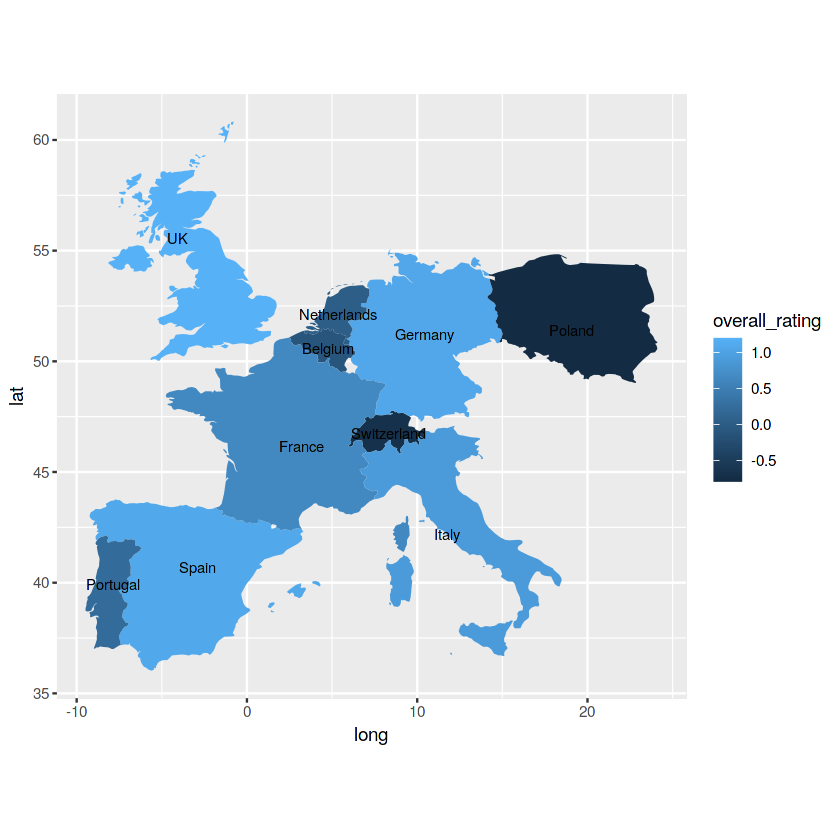

In [128]:
full_league_stat_14 <- team_players_2014 %>% left_join(player_2014, by = 'player_api_id') %>%
    select(c('league_name', 'overall_rating')) %>%
    group_by_at(1) %>%
    summarise_each(funs(mean(., na.rm=T))) %>% 
    left_join(league, by = 'league_name') %>% 
    left_join(data.frame(lDataFrames[1]), by = c('country_id'='id'))
full_league_stat_14[2,4] = 'UK'
full_league_stat_14
library(ggplot2)
require(maps)

# map of europe
some.eu.countries <- full_league_stat_14$name
eur <- map_data("world", region = some.eu.countries) %>% left_join(full_league_stat_14, by = c('region' = 'name'))
region.label <- eur %>% 
  group_by(region) %>%
  summarise_each(funs(mean), c(1:2))


ggplot(eur, aes(x = long, y = lat)) +
  geom_polygon(aes(group = group, fill = overall_rating))+
  geom_text(aes(label = region), data = region.label,  size = 3, hjust = 0.5)+
  coord_fixed(1.3) +
  theme(legend.position = "right")

# V. Spearman correlation test

In [129]:
player_att  <-  data.frame(lDataFrames[5])
player_att  <- select(player_att,player_api_id, date, overall_rating, potential)
player_att14 = select(with(player_att, player_att[(date >= "2014-07-18" & date <= "2015-05-31"),]),-c(date))
player_att15 = select(with(player_att, player_att[(date >= "2015-07-17" & date <= "2016-05-25"),]), -c(date))

# Average potential and overall_rating by player over a season
player14 <- player_att14 %>% group_by(player_api_id) %>% summarise_all("mean")
player15 <- player_att15 %>% group_by(player_api_id) %>% summarise_all("mean")

# Match players with teams
team14 <- select(team_players_2014,player_api_id,team_api_id)
team14 <- merge(team14,player14,by="player_api_id") %>% distinct()

team15 <- select(team_players_2015,player_api_id,team_api_id)
team15 <- merge(team15,player15,by="player_api_id") %>% distinct()

# find average player for each team for that season
player_ranking14 <- select(team14,-c(player_api_id)) %>% group_by(team_api_id) %>% summarise_all("mean")
player_ranking15 <- select(team15,-c(player_api_id)) %>% group_by(team_api_id) %>% summarise_all("mean")


# Create dataframe with team winning-rate and player's abilities
final14 <- arrange(merge(team_ranking14,player_ranking14, by="team_api_id"),-win_rate)
final15 <- arrange(merge(team_ranking15,player_ranking15, by="team_api_id"),-win_rate)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


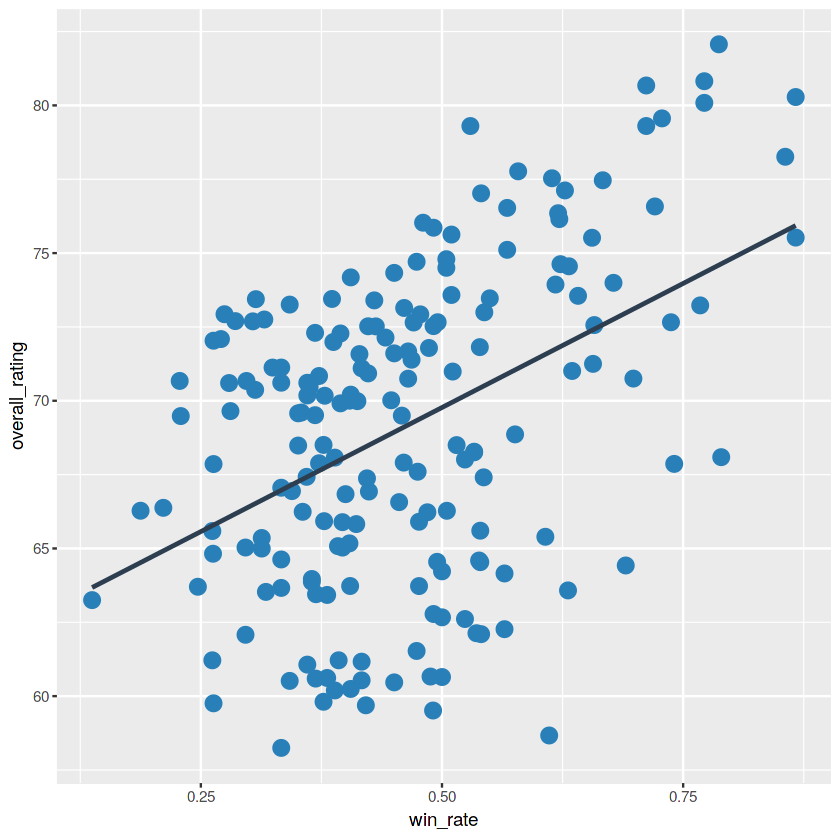

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


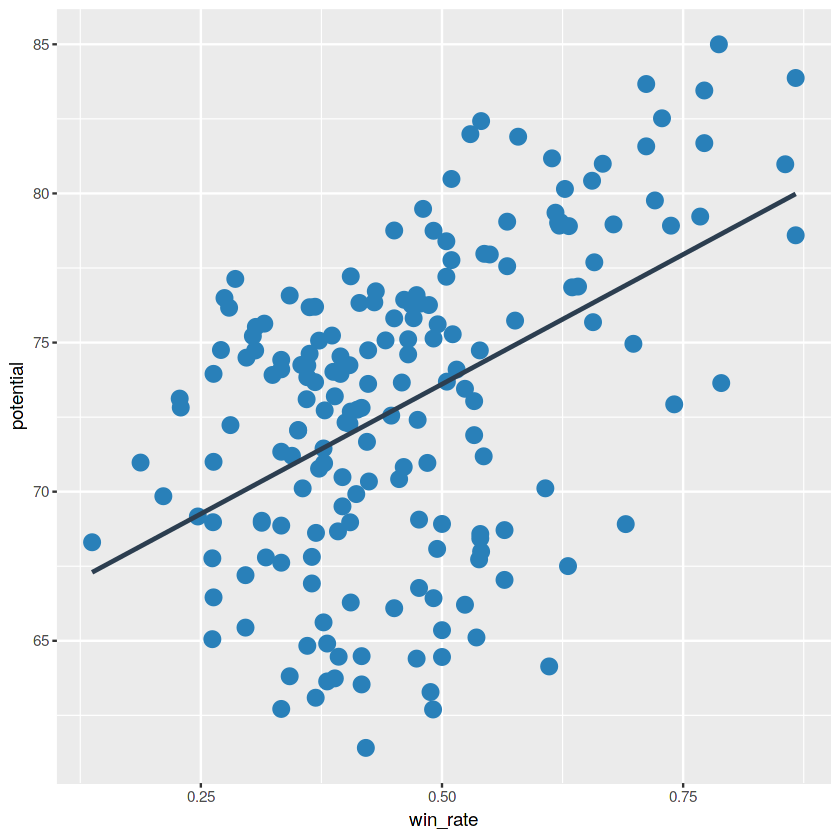

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


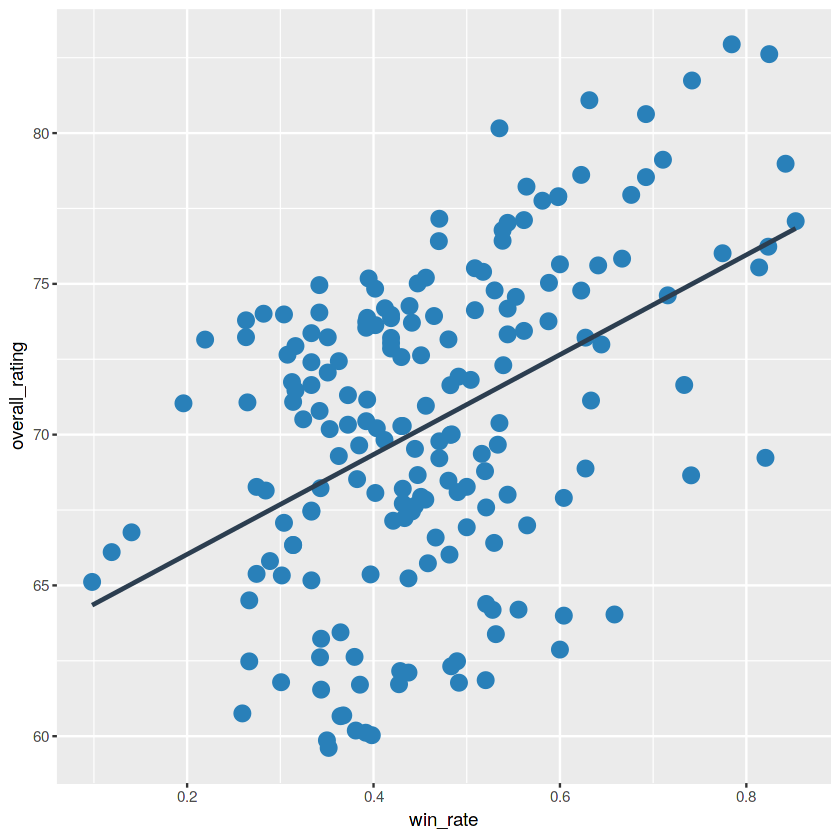

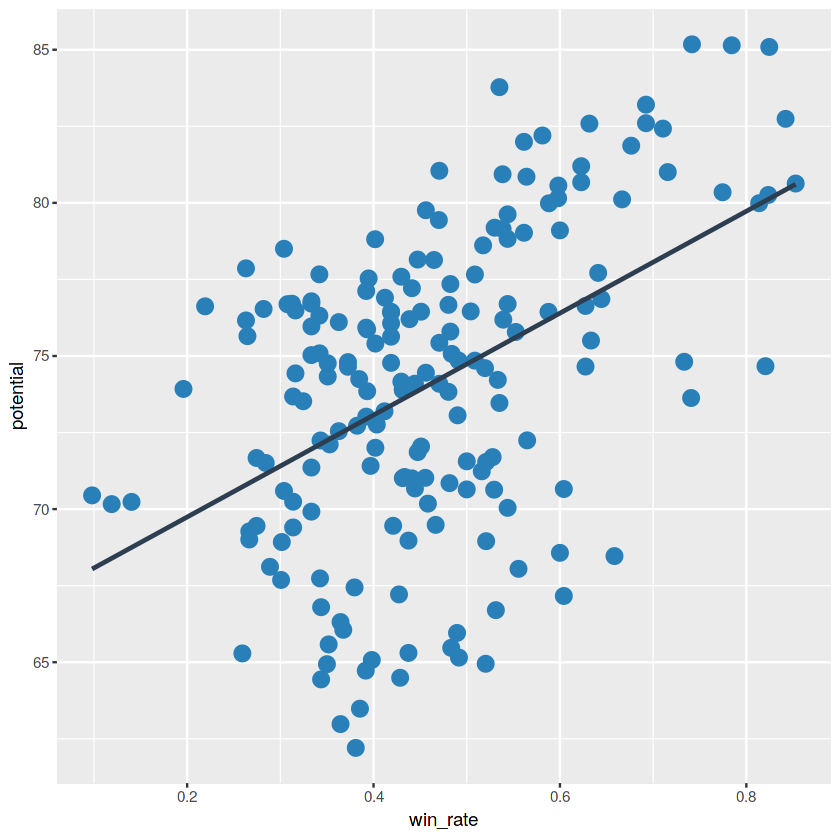

In [130]:
library(ggplot2)
ggplot(final14, aes(x=win_rate, y=overall_rating)) + 
  geom_point(color='#2980B9', size = 4) + 
  geom_smooth(method=lm, se=FALSE, fullrange=TRUE, color='#2C3E50')
ggplot(final14, aes(x=win_rate, y=potential)) + 
  geom_point(color='#2980B9', size = 4) + 
  geom_smooth(method=lm, se=FALSE, fullrange=TRUE, color='#2C3E50')


ggplot(final15, aes(x=win_rate, y=overall_rating)) + 
  geom_point(color='#2980B9', size = 4) + 
  geom_smooth(method=lm, se=FALSE, fullrange=TRUE, color='#2C3E50')
ggplot(final15, aes(x=win_rate, y=potential)) + 
  geom_point(color='#2980B9', size = 4) + 
  geom_smooth(method=lm, se=FALSE, fullrange=TRUE, color='#2C3E50')

In [131]:
# Correlate by Overall-rating and Winning-rate
corr14 <- cor.test(x=final14$win_rate, y=final14$overall_rating, method = 'spearman',conf.level = 0.95)
corr15 <- cor.test(x=final15$win_rate, y=final14$overall_rating, method = 'spearman',conf.level = 0.95)

corr14
corr15

Warning message in cor.test.default(x = final14$win_rate, y = final14$overall_rating, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = final15$win_rate, y = final14$overall_rating, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  final14$win_rate and final14$overall_rating
S = 637228, p-value = 6.129e-08
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3862306 



	Spearman's rank correlation rho

data:  final15$win_rate and final14$overall_rating
S = 636532, p-value = 5.789e-08
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3869005 


# V. Player feature analysis

### 1. Filter interested leagues

In [132]:
# filter only 3 leagues
player_name_2014 <- subset(team_players_2014$player_name,
  team_players_2014$league_name == "England Premier League" |
  team_players_2014$league_name == "Germany 1. Bundesliga" |
  team_players_2014$league_name == "Spain LIGA BBVA"
)
player_2014 <- subset(player_2014,
                      player_name %in% player_name_2014)
player_name_2015 <- subset(team_players_2015$player_name,
  team_players_2015$league_name == "England Premier League" |
  team_players_2015$league_name == "Germany 1. Bundesliga" |
  team_players_2015$league_name == "Spain LIGA BBVA"
)
player_2015 <- subset(player_2015,
                      player_name %in% player_name_2015)

## filter for EACH league
player_name_2014_eng <- subset(team_players_2014$player_name,
  team_players_2014$league_name == "England Premier League")
player_name_2014_ger <- subset(team_players_2014$player_name,
  team_players_2014$league_name == "Germany 1. Bundesliga")
player_name_2014_spa <- subset(team_players_2014$player_name,
  team_players_2014$league_name == "Spain LIGA BBVA")

player_2014_eng <- subset(player_2014,
                      player_name %in% player_name_2014_eng)

player_2014_ger <- subset(player_2014,
                          player_name %in% player_name_2014_ger)

player_2014_spa <- subset(player_2014,
                          player_name %in% player_name_2014_spa)

### 2. Linear regression


Call:
lm(formula = overall_rating ~ height + weight + crossing + finishing + 
    heading_accuracy + short_passing + volleys + dribbling + 
    curve + free_kick_accuracy + long_passing + ball_control + 
    acceleration + sprint_speed + agility + reactions + balance + 
    shot_power + jumping + stamina + strength + long_shots + 
    aggression + interceptions + positioning + vision + penalties + 
    marking + standing_tackle + sliding_tackle + gk_diving + 
    gk_handling + gk_kicking + gk_positioning + gk_reflexes + 
    left_foot + attack_high + attack_medium + defend_high + defend_medium, 
    data = player_2014, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.15461 -0.23294 -0.01385  0.23166  1.31429 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.3041198  0.1409905   2.157  0.03120 *  
height             -0.0427850  0.0221568  -1.931  0.05371 .  
weight              0.0008245  0.0181877   


Call:
lm(formula = overall_rating ~ height + weight + crossing + finishing + 
    heading_accuracy + short_passing + volleys + dribbling + 
    curve + free_kick_accuracy + long_passing + ball_control + 
    acceleration + sprint_speed + agility + reactions + balance + 
    shot_power + jumping + stamina + strength + long_shots + 
    aggression + interceptions + positioning + vision + penalties + 
    marking + standing_tackle + sliding_tackle + gk_diving + 
    gk_handling + gk_kicking + gk_positioning + gk_reflexes + 
    left_foot + attack_high + attack_medium + defend_high + defend_medium, 
    data = player_2014_eng, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.05449 -0.22287 -0.01109  0.26799  0.94655 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.229054   0.247706   0.925  0.35569    
height             -0.100508   0.037150  -2.705  0.00712 ** 
weight              0.013845   0.028236   


Call:
lm(formula = overall_rating ~ height + weight + crossing + finishing + 
    heading_accuracy + short_passing + volleys + dribbling + 
    curve + free_kick_accuracy + long_passing + ball_control + 
    acceleration + sprint_speed + agility + reactions + balance + 
    shot_power + jumping + stamina + strength + long_shots + 
    aggression + interceptions + positioning + vision + penalties + 
    marking + standing_tackle + sliding_tackle + gk_diving + 
    gk_handling + gk_kicking + gk_positioning + gk_reflexes + 
    left_foot + attack_high + attack_medium + defend_high + defend_medium, 
    data = player_2014_ger, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.89804 -0.18429  0.00017  0.18841  0.97761 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.008493   0.247069   0.034 0.972597    
height              0.027667   0.038584   0.717 0.473793    
weight              0.010023   0.033226   


Call:
lm(formula = overall_rating ~ height + weight + crossing + finishing + 
    heading_accuracy + short_passing + volleys + dribbling + 
    curve + free_kick_accuracy + long_passing + ball_control + 
    acceleration + sprint_speed + agility + reactions + balance + 
    shot_power + jumping + stamina + strength + long_shots + 
    aggression + interceptions + positioning + vision + penalties + 
    marking + standing_tackle + sliding_tackle + gk_diving + 
    gk_handling + gk_kicking + gk_positioning + gk_reflexes + 
    left_foot + attack_high + attack_medium + defend_high + defend_medium, 
    data = player_2014_spa, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.10241 -0.23797 -0.01666  0.24691  1.17256 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.787909   0.234183   3.365 0.000837 ***
height             -0.024359   0.038673  -0.630 0.529122    
weight              0.021743   0.036001   

Warning message:
“Use of `player_2014_eng$aggression` is discouraged. Use `aggression` instead.”
Warning message:
“Use of `player_2014_eng$overall_rating` is discouraged. Use `overall_rating` instead.”
Warning message:
“Use of `player_2014_eng$height` is discouraged. Use `height` instead.”
Warning message:
“Use of `player_2014_eng$stamina` is discouraged. Use `stamina` instead.”
Warning message:
“Removed 10 rows containing missing values (geom_point).”


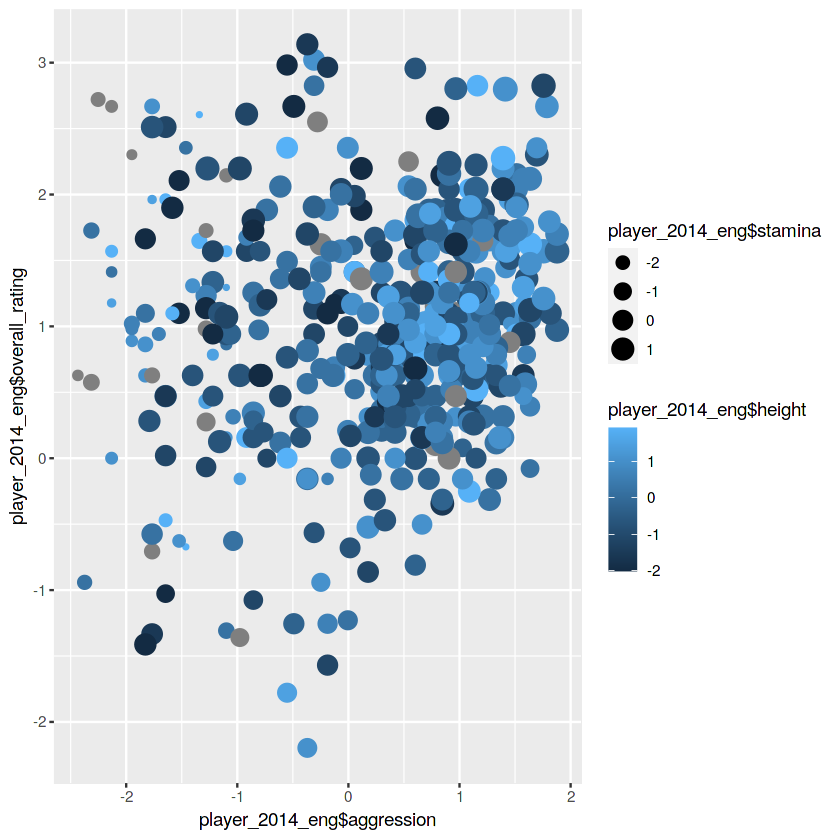

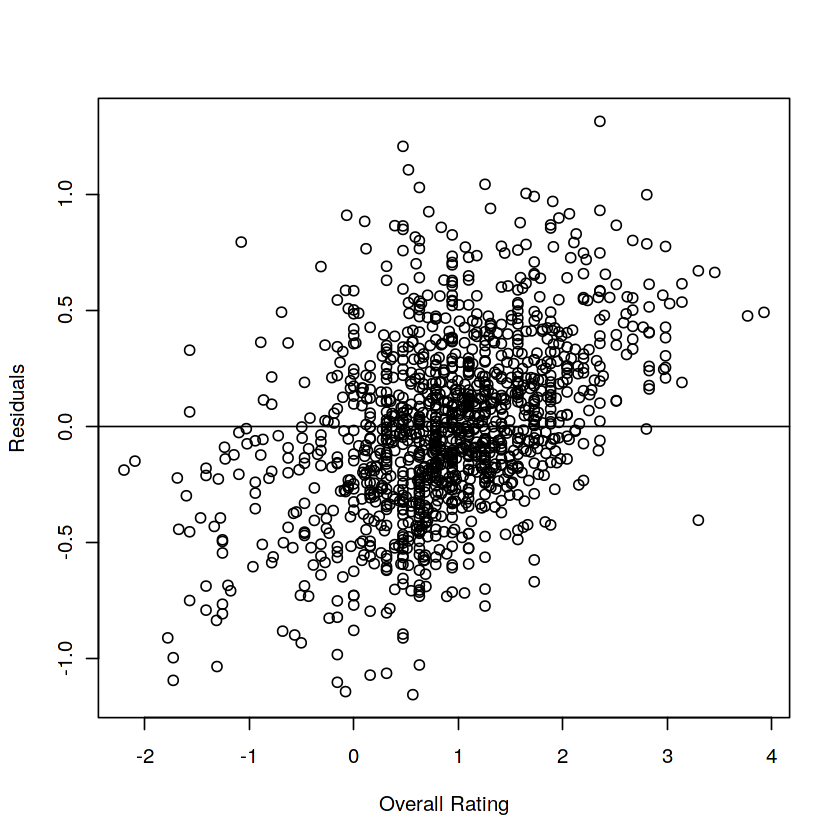

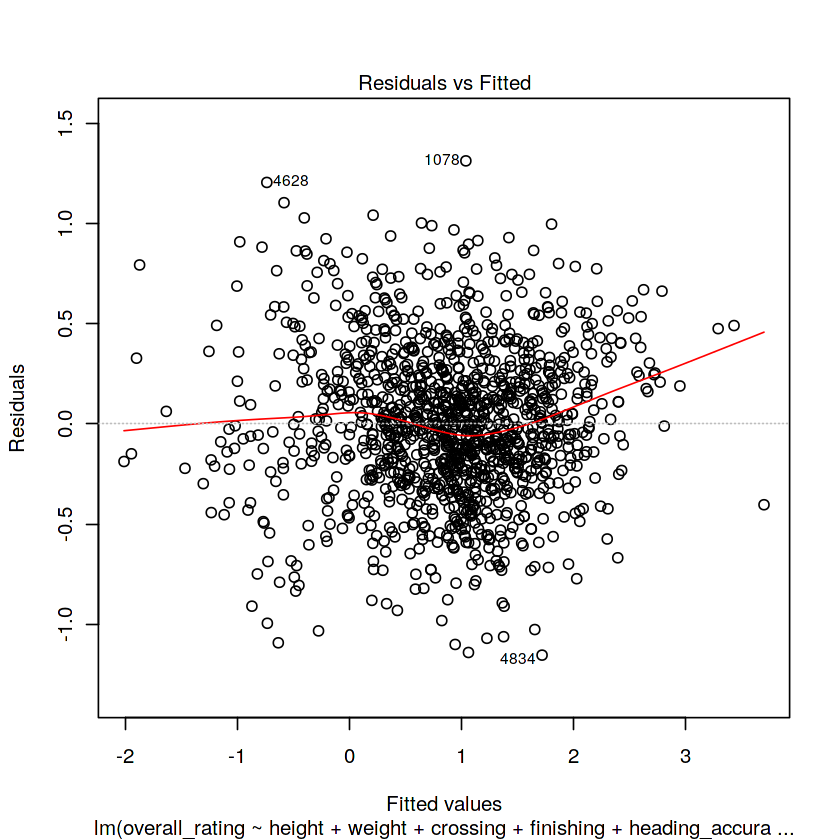

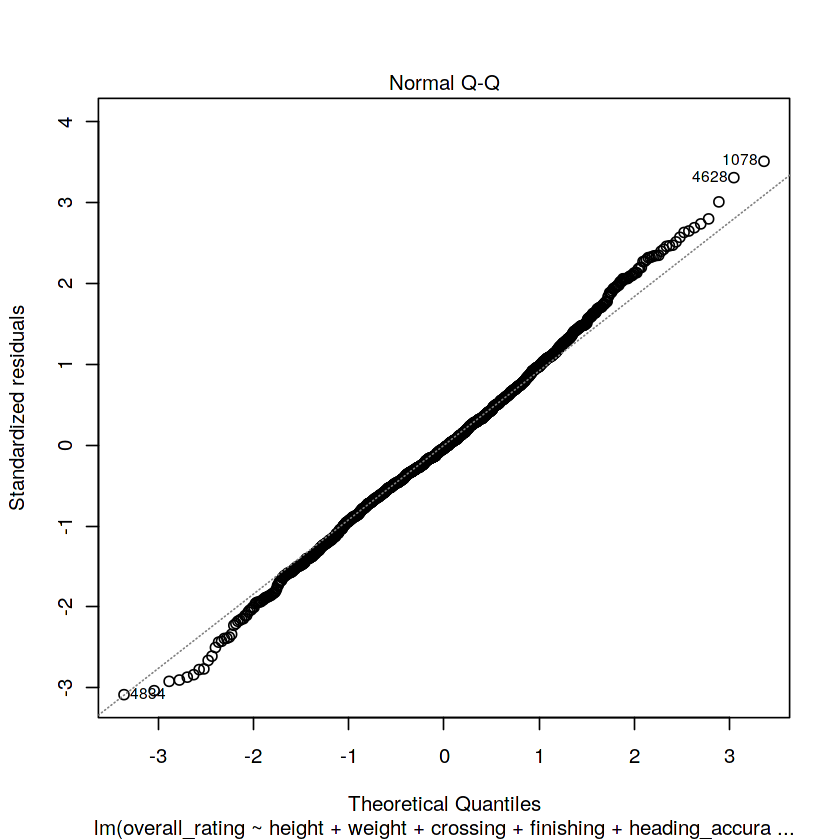

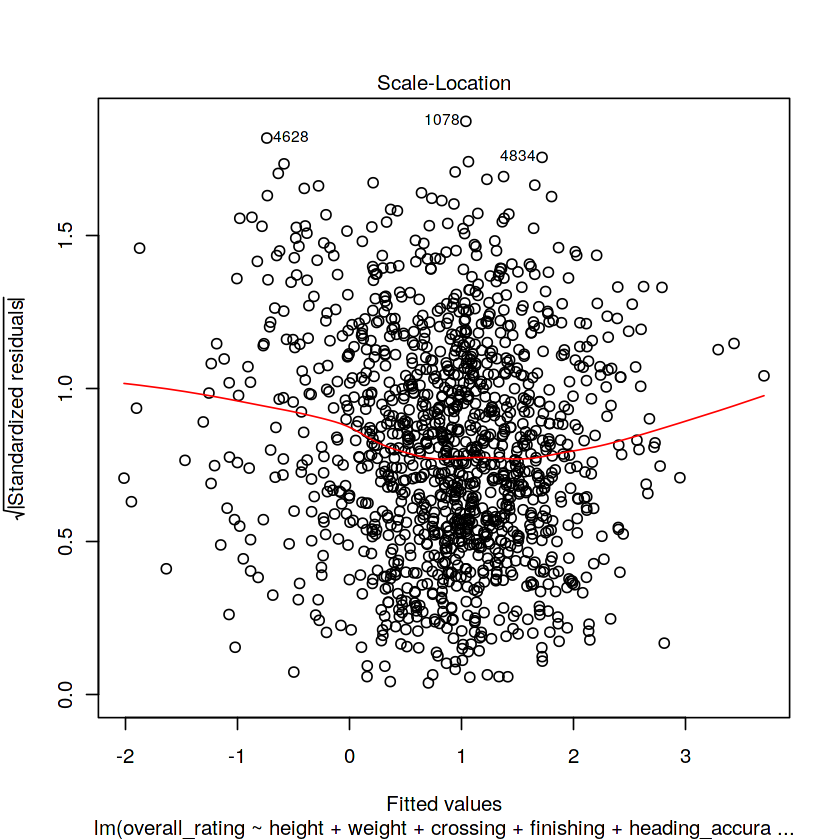

,ME,RMSE,MAE,MPE,MAPE
Test set,0.001631136,0.414209,0.3204022,10.30553,79.34527


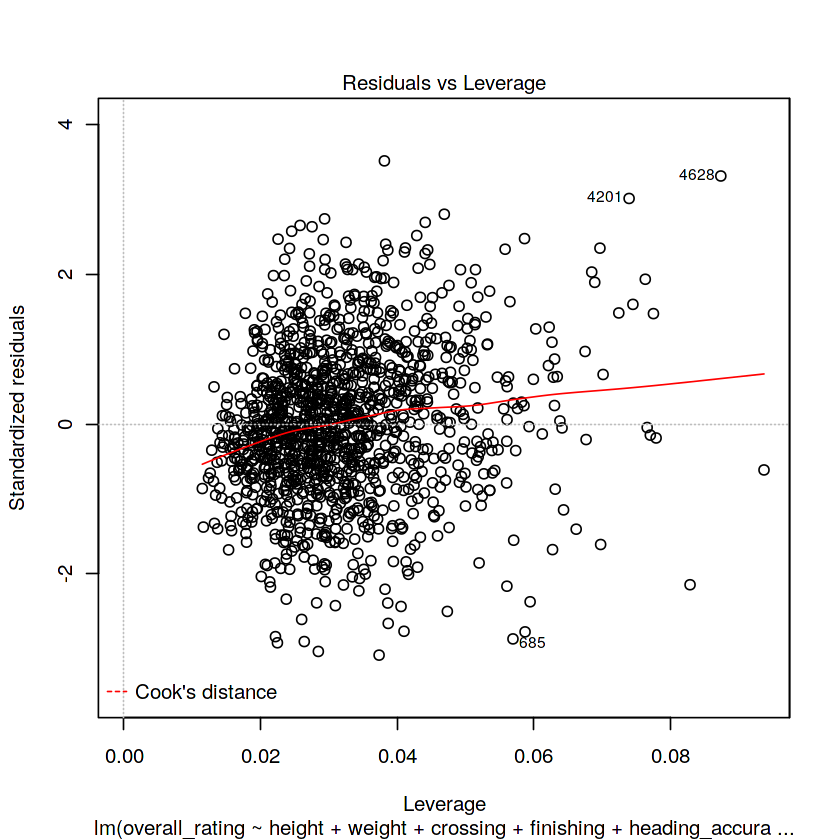

In [133]:
player_2014.lr <-
  lm(overall_rating ~ 
       height+weight+crossing+finishing+heading_accuracy+short_passing+
     volleys+dribbling+curve+free_kick_accuracy+long_passing+ball_control+
     acceleration+sprint_speed+agility+reactions+balance+shot_power+jumping+
     stamina+strength+long_shots+aggression+interceptions+positioning+vision+
     penalties+marking+standing_tackle+sliding_tackle+gk_diving+gk_handling+
     gk_kicking+gk_positioning+gk_reflexes+left_foot+attack_high+
     attack_medium+defend_high+defend_medium,
   na.action = na.exclude, data = player_2014)
summary(player_2014.lr)

player_2014_eng.lr <-
  lm(overall_rating ~ 
       height+weight+crossing+finishing+heading_accuracy+short_passing+
       volleys+dribbling+curve+free_kick_accuracy+long_passing+ball_control+
       acceleration+sprint_speed+agility+reactions+balance+shot_power+jumping+
       stamina+strength+long_shots+aggression+interceptions+positioning+vision+
       penalties+marking+standing_tackle+sliding_tackle+gk_diving+gk_handling+
       gk_kicking+gk_positioning+gk_reflexes+left_foot+attack_high+
       attack_medium+defend_high+defend_medium,
     na.action = na.exclude, data = player_2014_eng)
summary(player_2014_eng.lr)

player_2014_ger.lr <-
  lm(overall_rating ~ 
       height+weight+crossing+finishing+heading_accuracy+short_passing+
       volleys+dribbling+curve+free_kick_accuracy+long_passing+ball_control+
       acceleration+sprint_speed+agility+reactions+balance+shot_power+jumping+
       stamina+strength+long_shots+aggression+interceptions+positioning+vision+
       penalties+marking+standing_tackle+sliding_tackle+gk_diving+gk_handling+
       gk_kicking+gk_positioning+gk_reflexes+left_foot+attack_high+
       attack_medium+defend_high+defend_medium,
     na.action = na.exclude, data = player_2014_ger)
summary(player_2014_ger.lr)

player_2014_spa.lr <-
  lm(overall_rating ~ 
       height+weight+crossing+finishing+heading_accuracy+short_passing+
       volleys+dribbling+curve+free_kick_accuracy+long_passing+ball_control+
       acceleration+sprint_speed+agility+reactions+balance+shot_power+jumping+
       stamina+strength+long_shots+aggression+interceptions+positioning+vision+
       penalties+marking+standing_tackle+sliding_tackle+gk_diving+gk_handling+
       gk_kicking+gk_positioning+gk_reflexes+left_foot+attack_high+
       attack_medium+defend_high+defend_medium,
     na.action = na.exclude, data = player_2014_spa)
summary(player_2014_spa.lr)

library(ggplot2)
ggplot(data=player_2014_eng, 
       aes(x=player_2014_eng$aggression, y=player_2014_eng$overall_rating, 
           col=player_2014_eng$height, size=player_2014_eng$stamina)) + 
  geom_point()

player_2014.res <- resid(player_2014.lr)
plot(player_2014$overall_rating, player_2014.res,
     ylab="Residuals", xlab="Overall Rating")
abline(0,0)

plot(player_2014.lr)

player_2015.predict <- predict(player_2014.lr, player_2015[,c(6,7,14:51)],
        level=0.95)

library(forecast)
accuracy(player_2015.predict, player_2015$overall_rating)

# VI. Team features analysis

### 1. Filter interested leagues

In [134]:
team_id_2014 <- team_players_2014$team_api_id
team_2014 <- subset(team_2014,
                    team_api_id %in% team_id_2014)

team_id_2014_eng <- subset(team_players_2014$team_api_id,
                           team_players_2014$league_name == "England Premier League")
team_2014_eng <- subset(team_2014,
                        team_api_id %in% team_id_2014_eng)

team_id_2014_ger <- subset(team_players_2014$team_api_id,
                           team_players_2014$league_name == "Germany 1. Bundesliga")
team_2014_ger <- subset(team_2014,
                        team_api_id %in% team_id_2014_ger)

team_id_2014_spa <- subset(team_players_2014$team_api_id,
                           team_players_2014$league_name == "Spain LIGA BBVA")
team_2014_spa <- subset(team_2014,
                        team_api_id %in% team_id_2014_spa)

team_id_2015 <- team_players_2015$team_api_id
team_2015 <- subset(team_2015,
                    team_api_id %in% team_id_2015)

team_id_2015_eng <- subset(team_players_2015$team_api_id,
                           team_players_2015$league_name == "England Premier League")
team_2015_eng <- subset(team_2015,
                        team_api_id %in% team_id_2015_eng)

team_id_2015_ger <- subset(team_players_2015$team_api_id,
                           team_players_2015$league_name == "Germany 1. Bundesliga")
team_2015_ger <- subset(team_2015,
                        team_api_id %in% team_id_2015_ger)

team_id_2015_spa <- subset(team_players_2015$team_api_id,
                           team_players_2015$league_name == "Spain LIGA BBVA")
team_2015_spa <- subset(team_2015,
                        team_api_id %in% team_id_2015_spa)


# change dummies
team_2014$chanceCreationPositioning_organised <- ifelse(team_2014$chanceCreationPositioningClass == "Organised", 1, 0)
team_2015$chanceCreationPositioning_organised <- ifelse(team_2015$chanceCreationPositioningClass == "Organised", 1, 0)

team_2014$defenceDefenderLine_cover <- ifelse(team_2014$defenceDefenderLineClass == "Cover", 1, 0)
team_2015$defenceDefenderLine_cover <- ifelse(team_2015$defenceDefenderLineClass == "Cover", 1, 0)

### 2. PCA

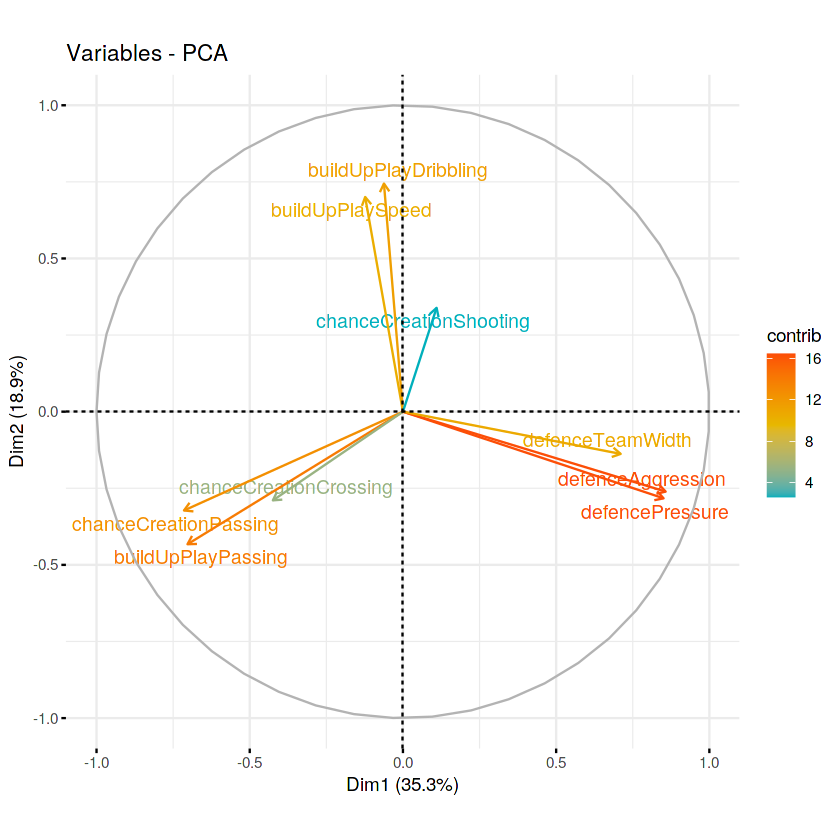

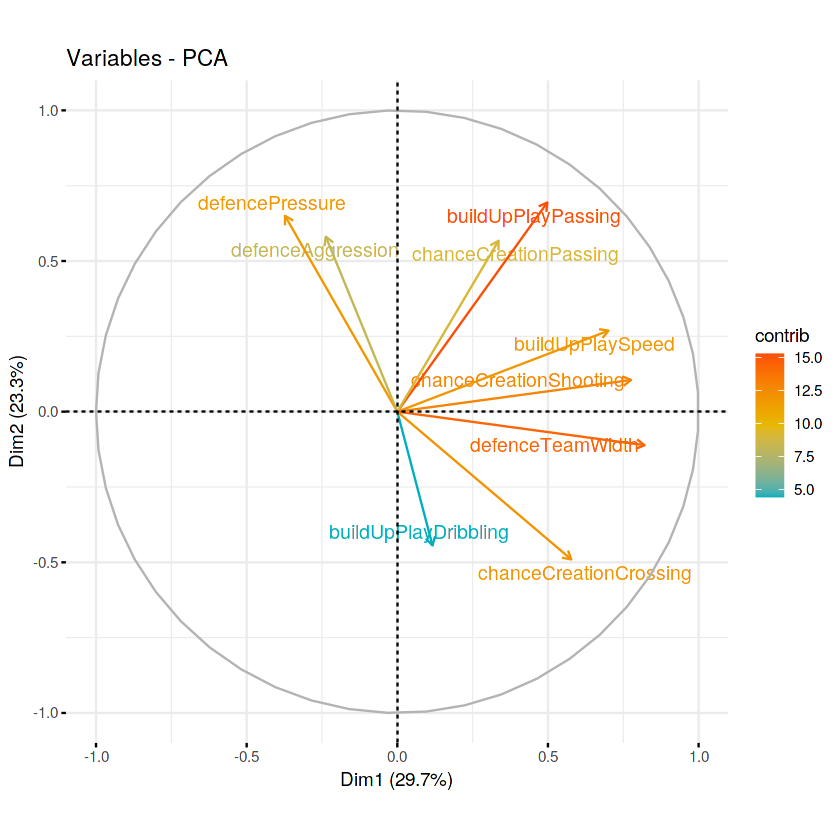

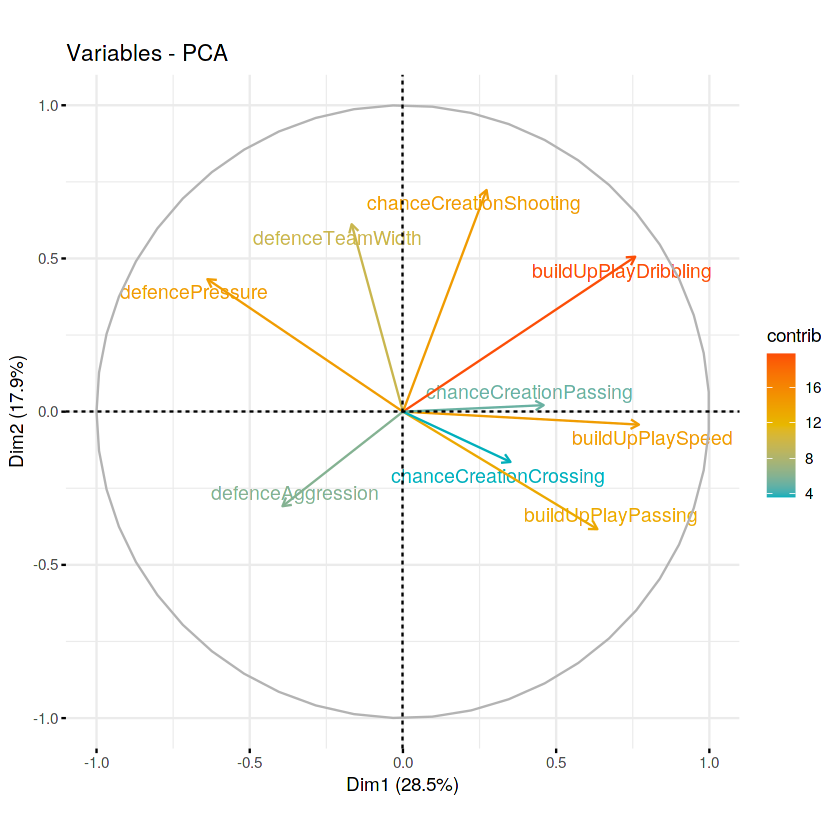

In [135]:
## England
team_2014_eng_num <- team_2014_eng[,c(6:11,13:15)]
eng.pca <- PCA(team_2014_eng_num, graph = FALSE)
fviz_pca_var(eng.pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE) # Avoid text overlapping)

## Germany
             
team_2014_ger_num <- team_2014_ger[,c(6:11,13:15)]
ger.pca <- PCA(team_2014_ger_num, graph = FALSE)
fviz_pca_var(ger.pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE) # Avoid text overlapping

## Spain
team_2014_spa_num <- team_2014_spa[,c(6:11,13:15)]
spa.pca <- PCA(team_2014_spa_num, graph = FALSE)
fviz_pca_var(spa.pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE) # Avoid text overlapping

### 3. Linear regression

In [136]:
### linear regression
library(forecast)

## England
team_2014_eng_win_rate.lr <- lm(win_rate ~ buildUpPlaySpeed+buildUpPlayDribbling+buildUpPlayPassing+
                                  chanceCreationPassing+chanceCreationCrossing+chanceCreationShooting+
                                  defencePressure+defenceAggression+defenceTeamWidth,
                                na.action = na.exclude, data = team_2014_eng)
summary(team_2014_eng_win_rate.lr)


## Germany
team_2014_ger_win_rate.lr <- lm(win_rate ~ buildUpPlaySpeed+buildUpPlayDribbling+buildUpPlayPassing+
                                  chanceCreationCrossing+chanceCreationShooting+
                                  defencePressure+defenceTeamWidth,
                                na.action = na.exclude, data = team_2014_ger)
summary(team_2014_ger_win_rate.lr)


## Spain
team_2014_spa_win_rate.lr <- lm(win_rate ~ buildUpPlaySpeed+buildUpPlayDribbling+buildUpPlayPassing+
                                  chanceCreationPassing+chanceCreationCrossing+chanceCreationShooting+
                                  defencePressure+defenceAggression+defenceTeamWidth,
                                na.action = na.exclude, data = team_2014_spa)
summary(team_2014_spa_win_rate.lr)



Call:
lm(formula = win_rate ~ buildUpPlaySpeed + buildUpPlayDribbling + 
    buildUpPlayPassing + chanceCreationPassing + chanceCreationCrossing + 
    chanceCreationShooting + defencePressure + defenceAggression + 
    defenceTeamWidth, data = team_2014_eng, na.action = na.exclude)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.185754 -0.040083 -0.000054  0.048371  0.117844 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.5391175  0.0818126   6.590 6.16e-05 ***
buildUpPlaySpeed       -0.0215921  0.0396623  -0.544  0.59810    
buildUpPlayDribbling    0.0849671  0.0393689   2.158  0.05628 .  
buildUpPlayPassing     -0.1139079  0.0352009  -3.236  0.00893 ** 
chanceCreationPassing  -0.0093859  0.0315291  -0.298  0.77203    
chanceCreationCrossing  0.0397995  0.0370317   1.075  0.30774    
chanceCreationShooting -0.0008946  0.0305423  -0.029  0.97721    
defencePressure        -0.0002767  0.0577208  -0.005  0.99


Call:
lm(formula = win_rate ~ buildUpPlaySpeed + buildUpPlayDribbling + 
    buildUpPlayPassing + chanceCreationCrossing + chanceCreationShooting + 
    defencePressure + defenceTeamWidth, data = team_2014_ger, 
    na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.12079 -0.06361 -0.01640  0.06644  0.15412 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.472255   0.035415  13.335 1.08e-07 ***
buildUpPlaySpeed        0.007147   0.026549   0.269   0.7932    
buildUpPlayDribbling   -0.077230   0.026790  -2.883   0.0163 *  
buildUpPlayPassing     -0.064667   0.039563  -1.635   0.1332    
chanceCreationCrossing  0.032921   0.027494   1.197   0.2588    
chanceCreationShooting -0.042990   0.036951  -1.163   0.2717    
defencePressure         0.079846   0.031326   2.549   0.0289 *  
defenceTeamWidth        0.008080   0.035056   0.231   0.8223    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.


Call:
lm(formula = win_rate ~ buildUpPlaySpeed + buildUpPlayDribbling + 
    buildUpPlayPassing + chanceCreationPassing + chanceCreationCrossing + 
    chanceCreationShooting + defencePressure + defenceAggression + 
    defenceTeamWidth, data = team_2014_spa, na.action = na.exclude)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.196410 -0.065715  0.006943  0.077067  0.196947 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.449583   0.058590   7.673 1.69e-05 ***
buildUpPlaySpeed        0.070756   0.055670   1.271   0.2325    
buildUpPlayDribbling   -0.142139   0.079000  -1.799   0.1022    
buildUpPlayPassing     -0.034734   0.038241  -0.908   0.3851    
chanceCreationPassing   0.060419   0.037377   1.616   0.1371    
chanceCreationCrossing -0.003464   0.050502  -0.069   0.9467    
chanceCreationShooting -0.009441   0.039512  -0.239   0.8160    
defencePressure         0.002617   0.056536   0.046   0.9640    
d

# VII. Win prediction

### 1. Gather independent variables

In [137]:
player_2014$left_foot <- ifelse(player_2014$preferred_foot == 'left', 1, 0)
player_2014$right_foot <- ifelse(player_2014$preferred_foot == 'right', 1, 0)
player_2015$left_foot <- ifelse(player_2015$preferred_foot == 'left', 1, 0)
player_2015$right_foot <- ifelse(player_2015$preferred_foot == 'right', 1, 0)
full_team_stat_14 <- team_players_2014 %>% left_join(player_2014, by = 'player_api_id') %>%
    select(-c('player_name.y', 'player_name.x', 'birthday', 'preferred_foot', 'date', 'id')) %>% 
    group_by_at(c(1:4, 6:8)) %>%
    summarise_each(funs(ave(.,na.rm=T)), c(9:47)) %>% 
    distinct() 
full_team_stat_14 <- left_join(full_team_stat_14, team_attr_2014, by = 'team_api_id') %>%
    select(-c('chanceCreationPositioningClass', 'defenceDefenderLineClass'))
full_team_stat_15 <- team_players_2015 %>% left_join(player_2015, by = 'player_api_id') %>%
    select(-c('player_name.y', 'player_name.x', 'birthday', 'preferred_foot', 'date', 'id')) %>% 
    group_by_at(c(1:4, 6:8)) %>%
    summarise_each(funs(ave(.,na.rm=T)), c(9:47)) %>% 
    distinct() 
full_team_stat_15 <- left_join(full_team_stat_15, team_attr_2015, by = 'team_api_id') %>%
    select(-c('chanceCreationPositioningClass', 'defenceDefenderLineClass'))
country = 'Spain'
full_team_stat_14_league <- full_team_stat_14 %>% 
    filter(season_start == 2014 & country_name == country) %>%
    ungroup() %>%
    select(-c('season_start', 'season_end', 'country_name', 'league_name', 'id'))
full_team_stat_15_league <- full_team_stat_15 %>% 
    filter(season_start == 2015 & country_name == country) %>%
    ungroup() %>%
    select(-c('season_start', 'season_end', 'country_name', 'league_name', 'id'))

In [138]:
head(full_team_stat_14_league)
head(full_team_stat_15_league)

team_api_id,team_long_name,team_short_name,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,⋯,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
<dbl>,<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
7869,Córdoba CF,COR,0.25084623,-0.05988475,-0.04392794,0.09636929,-0.06789137,0.08477995,0.2214033,⋯,2014-09-19,-1.4849335,0.4496864,0.4488087,-1.49888514,1.2984692,-0.456930340,-1.1304564,-0.9967634,-0.03478378
7878,Granada CF,GRA,0.08904332,-0.11687574,0.03921309,0.16346024,0.05556207,0.05974780,0.2501370,⋯,2014-09-19,-0.2400159,1.5739025,-1.2166501,1.54122925,1.5129119,0.008526691,0.4856149,-0.4226080,1.64191254
8302,Sevilla FC,SEV,0.55817794,0.27776399,0.36026746,0.64798077,0.08439138,0.37922197,0.4799436,⋯,2014-09-19,1.1086448,0.4496864,1.6979027,-0.03512636,0.3334767,-1.620572918,-0.8818301,0.1515475,0.38439030
8305,Getafe CF,GET,NA,NA,NA,NA,NA,NA,NA,⋯,2014-09-19,-2.0036491,-0.9243554,-0.9043765,0.52785778,-1.2748441,0.008526691,0.4856149,-0.4226080,-0.73340725
8315,Athletic Club de Bilbao,BIL,0.20495215,0.42309822,0.42840300,0.59673405,0.24613745,0.19157973,0.4173320,⋯,2014-09-19,-0.8624747,-1.0492683,-1.1125589,-0.14772319,1.5129119,-1.736937176,-1.0061432,1.7304750,1.78163724
8370,Rayo Vallecano,RAY,NA,NA,NA,NA,NA,NA,NA,⋯,2014-09-19,-0.9662178,0.3247735,-0.4880119,-1.04849782,-1.0604013,-0.573294598,NA,0.4386252,0.94328907


team_api_id,team_long_name,team_short_name,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,⋯,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
<dbl>,<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
7878,Granada CF,GRA,0.02824729,0.01109449,0.08901660,0.2820231,0.006408049,0.08235513,0.2535192,⋯,2015-09-10,0.2974819,0.3287350,1.0561023,0.9330350,1.1643908,0.01101917,0.2900507,-0.48226174,1.5862236
8302,Sevilla FC,SEV,0.28958507,0.14627221,0.36137566,0.5920175,0.037738784,0.28112801,0.4695759,⋯,2015-09-10,-0.1941017,0.6768073,0.3805389,0.0493545,-0.1024233,0.94324089,-0.4476869,-0.05576343,1.1273659
8305,Getafe CF,GET,0.39739631,0.19732528,-0.01695582,0.5545691,0.025966778,0.28731946,0.5161415,⋯,2015-09-10,NA,-0.7154820,-1.3083697,0.2702746,-1.5995672,-0.19614121,-0.3247306,-0.90876005,-0.4021598
8306,UD Las Palmas,LAS,0.22069031,0.20233107,-0.40438828,0.3796210,-0.083086364,0.12470858,0.1648151,⋯,2015-09-10,-0.8085811,0.9088555,-0.6328063,0.0493545,-1.2540724,0.21817955,0.9048319,-1.33525836,0.8214608
8315,Athletic Club de Bilbao,BIL,0.33484161,0.29093624,0.43761872,0.6094622,0.259163215,0.24220950,0.3433066,⋯,2015-09-10,-1.0543729,-0.1353615,-1.1957758,-0.2820257,0.8188961,-1.54268369,0.4130069,1.22373150,-0.2492072
8370,Rayo Vallecano,RAY,NA,NA,NA,NA,NA,NA,NA,⋯,2015-09-10,NA,0.5607832,-0.6328063,-0.9447861,-1.0237426,-0.40330159,1.0277882,0.51290098,1.7391762


### 2. Tabulate the matches

In [139]:
match_14 <- match %>% filter(season == '2014/2015')
match_stat_14 <- match_14 %>% right_join(full_team_stat_14_league, by = c('home_team_api_id'='team_api_id')) %>%
                right_join(full_team_stat_14_league, by = c('away_team_api_id'='team_api_id')) %>%
                select_at(c(7:11, 44:92, 95:143)) %>%
                select(-c('date', 'date.y'))
match_15 <- match %>% filter(season == '2014/2015')
match_stat_15 <- match_15 %>% right_join(full_team_stat_15_league, by = c('home_team_api_id'='team_api_id')) %>%
                right_join(full_team_stat_15_league, by = c('away_team_api_id'='team_api_id')) %>%
                select_at(c(7:11, 44:92, 95:143)) %>%
                select(-c('date', 'date.y')) %>%
                drop_na()
match_stat_14$result = ifelse(match_stat_14$away_team_goal < match_stat_14$home_team_goal, 1, 0)
result = ifelse(match_stat_14$away_team_goal < match_stat_14$home_team_goal, 1, 0)
match_stat_15$result = ifelse(match_stat_15$away_team_goal < match_stat_15$home_team_goal, 1, 0)

### 3. Logistic regression

In [140]:
cor(match_stat_14, use = "complete.obs")

,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,crossing.x,finishing.x,heading_accuracy.x,short_passing.x,volleys.x,⋯,buildUpPlaySpeed.y,buildUpPlayDribbling.y,buildUpPlayPassing.y,chanceCreationPassing.y,chanceCreationCrossing.y,chanceCreationShooting.y,defencePressure.y,defenceAggression.y,defenceTeamWidth.y,result
match_api_id,1.0000000000,-0.0008652925,0.0649585272,0.01922476,-0.10714767,-0.0009335197,-0.03453361,-0.03331127,-0.013734307,0.020632874,⋯,-0.0604203496,-0.1005604605,3.196731e-02,0.055970330,7.058748e-02,-0.032906383,1.639580e-02,0.0228898872,0.02661010,0.01832782
home_team_api_id,-0.0008652925,1.0000000000,-0.0909090909,0.03705880,0.03301133,-0.0197517527,0.27846690,-0.11853118,0.084047349,0.067545894,⋯,0.0166694272,0.0440293323,-1.919239e-02,0.012471151,5.012363e-02,-0.033946279,-4.731497e-02,-0.0100966456,0.01867292,0.03341895
away_team_api_id,0.0649585272,-0.0909090909,1.0000000000,-0.13092403,-0.08411010,0.0017956139,-0.02531517,0.01077556,-0.007640668,-0.006140536,⋯,-0.1833636996,-0.4843226549,2.111163e-01,-0.137182662,-5.513600e-01,0.373409065,5.204647e-01,0.1110631017,-0.20540209,-0.10976039
home_team_goal,0.0192247591,0.0370588048,-0.1309240267,1.00000000,-0.11174872,0.4792596219,0.47760103,0.47574137,0.511725146,0.383818859,⋯,0.0816617219,0.1511226720,-1.280757e-03,0.002467257,1.434777e-02,-0.029740511,-2.279275e-02,0.0279937267,0.02019583,0.65834692
away_team_goal,-0.1071476671,0.0330113280,-0.0841100976,-0.11174872,1.00000000,-0.2204391010,-0.13351653,-0.23949080,-0.227195296,-0.167410348,⋯,0.0703392188,0.1209034250,-7.819089e-02,0.313988012,-9.827961e-02,0.154853109,-7.390486e-02,-0.1018659748,0.14822144,-0.48717951
crossing.x,-0.0009335197,-0.0197517527,0.0017956139,0.47925962,-0.22043910,1.0000000000,0.73349615,0.80637995,0.872578482,0.777423236,⋯,-0.0009395175,-0.0152159193,1.832207e-02,-0.035410873,8.530609e-03,-0.033077156,-3.587819e-03,0.0245089662,-0.02268143,0.42143629
finishing.x,-0.0345336051,0.2784668977,-0.0253151725,0.47760103,-0.13351653,0.7334961506,1.00000000,0.75078995,0.892676102,0.845368768,⋯,-0.0058021909,0.0134569502,8.894204e-03,-0.030205491,2.193124e-02,-0.043229728,-1.215564e-02,-0.0210773325,-0.05174290,0.37439675
heading_accuracy.x,-0.0333112696,-0.1185311839,0.0107755622,0.47574137,-0.23949080,0.8063799514,0.75078995,1.00000000,0.914534862,0.758560581,⋯,-0.0022731422,-0.0018454403,2.585916e-02,-0.049468825,-2.448669e-02,-0.004548857,-6.525387e-04,0.0057816917,-0.03934656,0.44220161
short_passing.x,-0.0137343065,0.0840473491,-0.0076406681,0.51172515,-0.22719530,0.8725784816,0.89267610,0.91453486,1.000000000,0.823941659,⋯,-0.0018585977,0.0028708019,2.718565e-02,-0.036199805,3.603399e-03,-0.025845713,-7.688655e-03,-0.0026821003,-0.04554696,0.46724202
volleys.x,0.0206328739,0.0675458942,-0.0061405358,0.38381886,-0.16741035,0.7774232359,0.84536877,0.75856058,0.823941659,1.000000000,⋯,0.0042223021,-0.0068947692,2.932158e-02,-0.037141439,-3.842887e-03,-0.052090678,-3.326450e-02,-0.0096062575,-0.06329131,0.35292141


In [141]:
# First pass
d <- cbind(result, match_stat_14[6:98])
lmf <- reformulate(names(d)[-1], names(d[1]))
model.fit <- glm(lmf, data = match_stat_14, family="binomial", na.action = na.omit)

# Eliminate correlated features
nn <- names(na.exclude(model.fit$coefficients))[-1]
lmf <- reformulate(nn, 'result')
model.fit <- glm(lmf, data = match_stat_14, family="binomial", na.action = na.omit)

### 4. Prediction

[1] 0.7361111

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



Hosmer and Lemeshow Goodness-of-Fit Test 

Call:
glm(formula = lmf, family = "binomial", data = match_stat_14, 
    na.action = na.omit)
 ChiSquare df   P_value
  3.581472  8 0.8927755

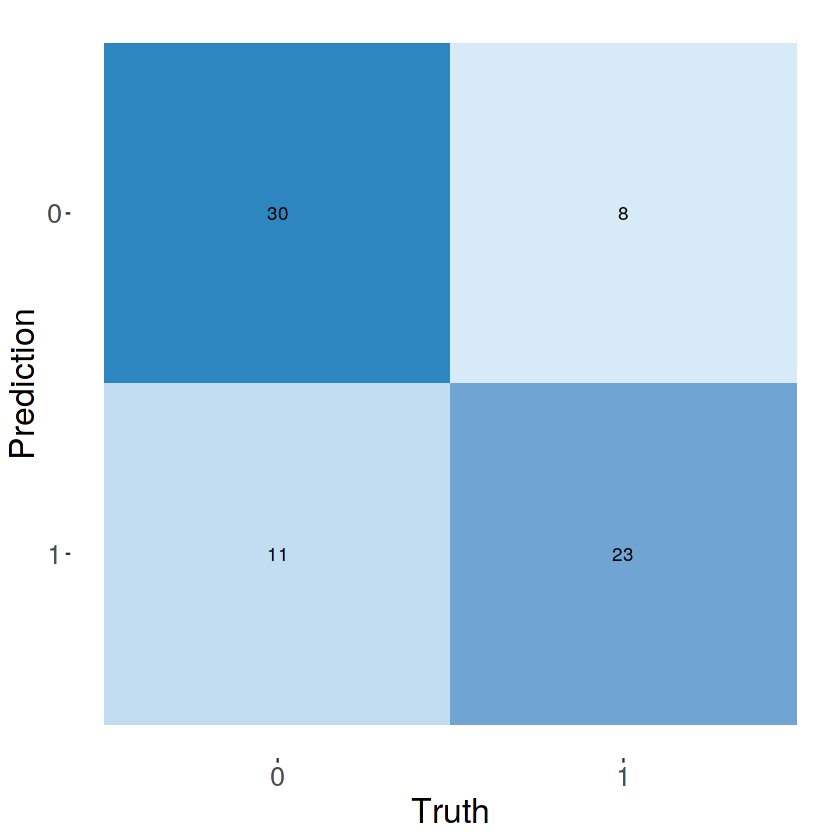

In [142]:
# Prediction
model.prob = predict(model.fit, match_stat_15, type="response")
model.pred = rep(0, dim(match_stat_15)[1])
model.pred[model.prob > .5] = 1
a<- table(model.pred, match_stat_15$result)
mean(model.pred == match_stat_15$result)
# The confusion matrix from a single assessment set (i.e. fold)
cm <- conf_mat(a, match_stat_15$result, model.pred)
autoplot(cm, type = "heatmap") +
  scale_fill_gradient(low="#D6EAF8",high = "#2E86C1") +
  theme(text = element_text(size=20))
HLtest(model = model.fit)

### 5. League competitiveness


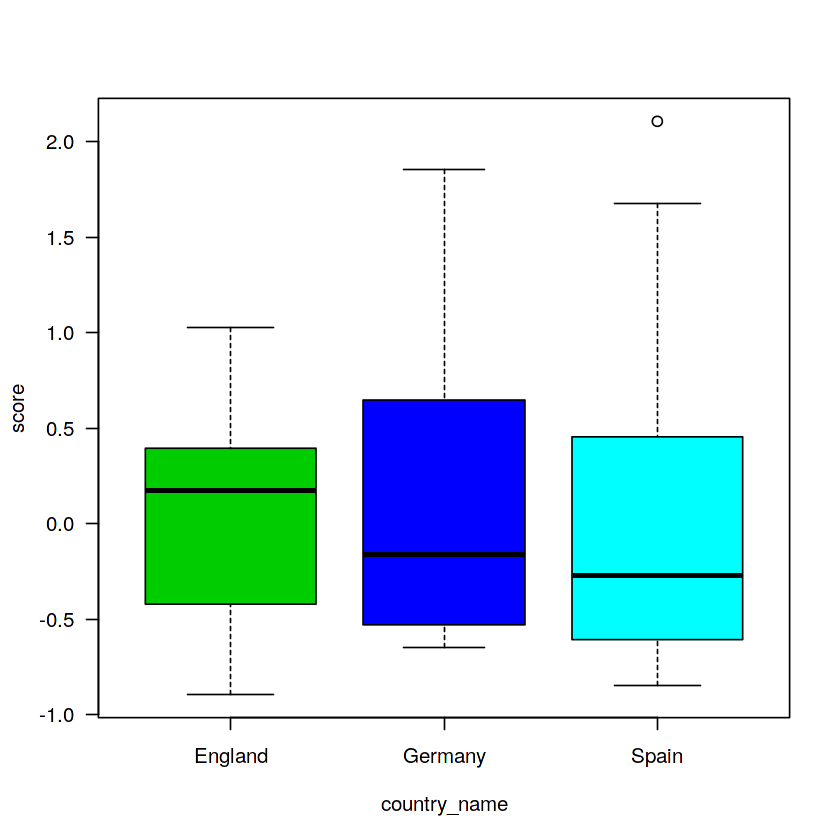

In [143]:
data <- left_join(team_ranking15, full_team_stat_15, by = 'team_api_id')
eng <- data %>% filter(country_name %in% c('England', 'Germany', 'Spain'))
boxplot(score ~ country_name, data = eng,
        varwidth = TRUE, las = 1, col = 3:5)

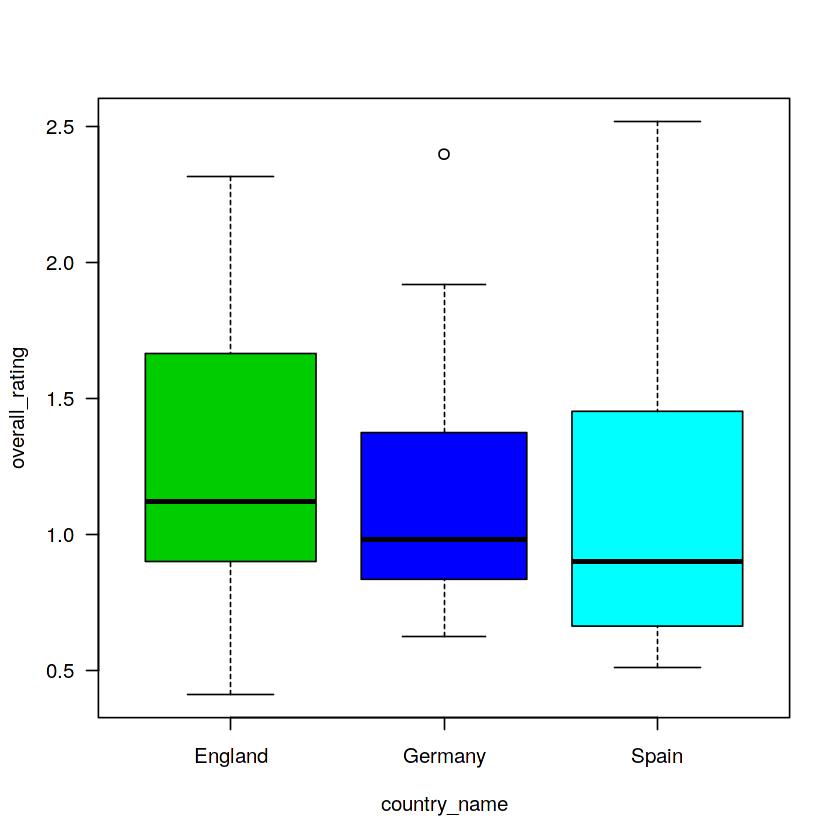

In [145]:
data <- team_players_2014 %>% left_join(player_2014, by = 'player_api_id') %>%
    select(c('team_api_id', 'overall_rating')) %>%
    group_by_at(1) %>%
    summarise_each(funs(mean(., na.rm=T))) %>%
    left_join(full_team_stat_15, by = 'team_api_id')
eng <- data %>% filter(country_name %in% c('England', 'Germany', 'Spain'))
boxplot(overall_rating ~ country_name, data = eng,
        varwidth = TRUE, las = 1, col = 3:5)

# VIII. Home advantage

In [146]:
country <-  data.frame(lDataFrames[1])
country <- select(country, id, name) %>% rename(country_id = id)  %>% rename(country_name = name)   # use country_id as key for join
match <- data.frame(lDataFrames[3])

match <- match %>% select(match_api_id,country_id, season,home_team_api_id,home_team_goal, away_team_goal)
match$home_score <- (match$home_team_goal - match$away_team_goal)
match$away_score <- (match$away_team_goal - match$home_team_goal)
match <- left_join(match, country, by = "country_id")

match$home_win_rate <- as.numeric(lapply(match$home_score,FUN=scoring))
match$away_win_rate <- as.numeric(lapply(match$away_score,FUN=scoring))
match <- match %>% select(season,country_name,home_win_rate,away_win_rate)

match15 = with(match, match[(season=='2015/2016'),])
match15 <- match15 %>% 
            group_by(country_name) %>% 
               summarise_at(vars("home_win_rate", "away_win_rate"), mean)
match15$home_adv <-  (match15$home_win_rate - match15$away_win_rate)*100
match15[2,1] = 'UK'
match15
match8 = with(match, match[(season=='2008/2009'),])
match8 <- match8 %>% 
            group_by(country_name) %>% 
               summarise_at(vars("home_win_rate", "away_win_rate"), mean)
match8$home_adv <-  (match8$home_win_rate - match8$away_win_rate)*100
match8[2,1] = 'UK'
match8

country_name,home_win_rate,away_win_rate,home_adv
<chr>,<dbl>,<dbl>,<dbl>
Belgium,0.5611111,0.3569444,20.416667
UK,0.5070175,0.3991228,10.789474
France,0.5157895,0.3894737,12.631579
Germany,0.5185185,0.4041394,11.437908
Italy,0.5438596,0.3728070,17.105263
Netherlands,0.5283224,0.3910675,13.725490
Poland,0.4819444,0.4152778,6.666667
Portugal,0.5174292,0.3997821,11.764706
Scotland,0.4839181,0.4400585,4.385965


country_name,home_win_rate,away_win_rate,home_adv
<chr>,<dbl>,<dbl>,<dbl>
Belgium,0.5599129,0.3671024,19.28105
UK,0.5403509,0.3745614,16.57895
France,0.5324561,0.3692982,16.31579
Germany,0.5610022,0.3583878,20.26144
Italy,0.5885965,0.3280702,26.05263
Netherlands,0.5631808,0.3540305,20.91503
Poland,0.5777778,0.3402778,23.75000
Portugal,0.5347222,0.3763889,15.83333
Scotland,0.5073099,0.4064327,10.08772


In [ ]:
require(maps)

# map of europe
some.eu.countries <- match8$country_name
eur <- map_data("world", region = some.eu.countries) %>% left_join(match8, by = c('region' = 'country_name'))
region.label <- eur %>% 
  group_by(region) %>%
  summarise_each(funs(mean), c(1:2))

ggplot(eur, aes(x = long, y = lat)) +
  geom_polygon(aes(group = group, fill = home_adv))+
  geom_text(aes(label = region), data = region.label,  size = 4, hjust = 0.5, color="black")+
  coord_fixed(1.3) +
  scale_fill_viridis_c(option = "C",direction = -1,alpha = 1,begin = 0.1,end = 1, limits=c(5, 27),guide_legend(title="Home advantage in %"))+
  ggtitle("Home advantage in 2008/2009 season") +
  theme_void()+
  theme(legend.position = "right",plot.title = element_text(hjust = 0.5))